# Gaussian Process Regression
This notebook introduces the theory underpinning Gaussian process regression and provides a basic walk-through in python. 

The goal of regression is to predict the value of one or more continuous target variables $y$ given a $D$-dimensional vector $x \in \mathbb{R}^D$ of input variables. More specifically, given a training data set of $N$ observations $\mathbf{X} = \{x_n\}_1^N$, together with corresponding target values $\mathbf{Y} = \{y_n\}_1^N$, the task of regression is to predict the value of $y$ for a new value of $x$. The target and observed variates are related through a mapping,

$$f : X \rightarrow Y$$

where $f$ indicates the mapping. 

Specifying parametric models for regression problems can be tricky because it requires a lot of knowledge about the data. From a Bayesian's perspective this could be viewed as not only having uncertainty in the parameters of the mapping but also in the form of the mapping itself. 

We would therefore like to formulate our uncertainty about the mapping into a prior over mappings and then use Bayes rule to reach the posterior. However, this requires us to formulate a prior over a space of functions! Luckily, a Gaussian process can be used to represent a prior distribution over a space of functions. No parametric form of the underlying function needs to be specified as Gaussian processes are non-parametric models.

**Definition**: _A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution_ ([Rasmussen and Williams](http://www.gaussianprocess.org/gpml/)).

A Gaussian process is completely specified by its mean function $m(\mathbf{x})$ and its covariance function $k(\mathbf{x}, \mathbf{x}')$,

\begin{align}
m(\mathbf{x}) &= \mathbb{E}[f(\mathbf{x})], \newline
k(\mathbf{x}, \mathbf{x}') &= \mathbb{E}[(f(\mathbf{x}) - m(\mathbf{x}))(f(\mathbf{x}') - m(\mathbf{x}'))].
\end{align}

and we can write the Gaussian process as,

$$f(\mathbf{x}) \sim \mathcal{GP}(m(\mathbf{x}), k(\mathbf{x}, \mathbf{x}')).$$

### Bayesian Inference Recap

In Bayesian inference we seek to update a statistical hypothesis (our prior distribution $p(\mathbf{\theta})$) when we observe data $\mathbf{Y}$. Bayesian inference derives the posterior probability $p(\mathbf{X}|\mathbf{Y})$ from the prior probability $p(\mathbf{X})$ and the likelihood function $p(\mathbf{Y}|\mathbf{X})$ (a statistical model for the observed data) using Bayes rule,

$$p(\mathbf{X}|\mathbf{Y}) = \frac{p(\mathbf{Y}|\mathbf{X})p(\mathbf{X})}{p(\mathbf{Y})},$$

where $p(\mathbf{Y})$ is known as the marginal likelihood (or evidence). Often the posterior is not analytically tractable due to the integral,

$$p(\mathbf{Y}) = \int p(\mathbf{Y}|\mathbf{X})p(\mathbf{X}) d\mathbf{X},$$

however, in the case of a Gaussian likelihood and a Gaussian process prior, the posterior takes the form of a Gaussian process over functions and is analytically tractable (hurray!).

We are often interested in the log marginal likelihood $\text{log} p(\mathbf{Y})$ and use it (or approximations) as an objective function in our learning algorithms.

### Bayesian Inference with Gaussian Processes
Lets now build a Bayesian model for Gaussian process regression. First we formulate a prior over the output of the function as a Gaussian process,

$$p(f|\mathbf{X}, \mathbf{\theta}) = \mathcal{N}(\mathbf{0}, K(\mathbf{X}, \mathbf{X})),$$

where $K( \cdot, \cdot )$ is the covariance function and $\mathbf{\theta}$ represents the hyper-parameters of the process. Here we have assumed that the data is translated to have zero mean so we do not need a mean function in our prior. Lets assume that our likelihood takes the form,

$$p(\mathbf{Y}|f) \sim \mathcal{N}(f, \sigma_n^2\mathbf{I}),$$

that is, we assume our observations are subject to additive i.i.d. Gaussian noise. Making the assumptions that $\mathbf{X}$ and $\mathbf{\theta}$ are independent and that $\mathbf{Y}$ is only dependent on $f$, the joint distribution of the full model can be written as,

$$p(\mathbf{Y}, \mathbf{X}, \mathbf{f}, \mathbf{\theta}) = p(\mathbf{Y} | \mathbf{f}) p(\mathbf{f} | \mathbf{X}, \mathbf{\theta}) p(\mathbf{X}) p(\mathbf{\theta}),$$

which can be represented as a graphical model:

![](images/graphical-model.png "Graphical model of the full joint distribution")

#### Sidenote on marginal likelihood
>Our model now contains the variable $\mathbf{f}$ which we are not particularly intereseted in. We have chosen to model the relationship between $\mathbf{Y}$ and $\mathbf{f}$ and also between $\mathbf{f}$ and $\mathbf{X}$ even though we are really interested in the relationship between $\mathbf{Y}$ and $\mathbf{X}$. This is because it enables us to model the uncertainty in each of these steps, more specifically, the uncertainty in our beliefs of the functions and the uncertainty in how our model $\mathbf{f}$ generated the data $\mathbf{Y}$.

>As we are not interested in $\mathbf{f}$ directly we need to marginalise it out by calculating the following integral,

>$$p(\mathbf{Y} | \mathbf{X}, \mathbf{\theta}) = \int p(\mathbf{Y}|f) p(f|\mathbf{X}, \mathbf{\theta}) df.$$

>This marginalisation is an integral performed over $f$ with the aim of removing $f$ from the distribution of $\mathbf{Y}$. When it is computed every function that "exists" is tested and checked how likely it is to fit the data. The Gaussian likelihood $p(\mathbf{Y} | f)$ tells us how well the data fits the model and $p(f | \mathbf{X}, \mathbf{\theta})$ is our Gaussian process prior. Carrying out this marginalisation involves combining a Gaussian likelihood and a Gaussian prior so (due to the marginalisation property) we obtain another Gaussian distribution (by computing a Gaussian integral). Thus by using the prior we obtain an ”expectation” for the fit of the data and as this ”expectation” is still a distribution some uncertainty filters. As these are two independent Gaussian distributions the new covariance (uncertainty term) is just the sum of the two respective covariances. After the marginalisation is carried out $\mathbf{Y}$ is no longer dependent on $f$, however, it is dependent on $\mathbf{\theta}$.

>We will refer back to this later when we wish to infer the hyperparameters from our data by maximising the log marginal likelihood $\text{log} p(\mathbf{Y}|\mathbf{X})$.

## Let's Begin
Lets now begin to implement Gaussian process regression in Python. For more detailed coverage of the information provided here please refer to [Rasmussen and Williams book (Gaussian Processes for Machine Learning)](http://www.gaussianprocess.org/gpml/).

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.spatial.distance import cdist

To begin with we need to specify our Gaussian process prior. As we are assuming a zero mean function we only need to specify the covariance function. We will only consider the squared exponential (SE) covariance function, however, other covariance functions exist.
The covariance function specifies the covariance between pairs of random variables,

$$ \text{cov}(f(\mathbf{x}_p), f(\mathbf{x}_q)) = k(\mathbf{x}_p, \mathbf{x}_q) = \text{exp}(- \frac{1}{2}|\mathbf{x}_p - \mathbf{x}_q|^2).$$

The characteristic lengthscale of this equation is around 1. By replacing $|\mathbf{x}_p - \mathbf{x}_q|$ with $\frac{|\mathbf{x}_p - \mathbf{x}_q|}{l}$, where $l$ is a positive constant, we can control the characteristic lengthscale. We can also control the variation of function values from their mean by introducing the signal variance $\sigma_f^2$. Small values of $\sigma_f^2$ characterise functions that stay close to their mean value and larger values allow more variation. However, if the signal variance is made too large then the modelled function may chase outliers. Lets now implement the squared exponential covariance function.

In [121]:
def kernel(x1, x2, var_f, l):
    """Squared exponential kernel"""
    return var_f * np.exp((-cdist(x1, x2)**2) / (2*l**2))

This specification of a covariance function implies a distribution over functions. We can visualise this by drawing samples from the "distribution over functions" at a fixed number of points. Lets select a number of test input points $X_*$ to evaluate.

In [122]:
n = 100  # number of test points
x_min = -5
x_max = 5
x_star = np.linspace(x_min*1.4, x_max*1.4, n).reshape(-1,1) # points we're going to make predictions at

Using this covariance matrix and our test input points, lets generate a random Gaussian vector,

$$\mathbf{f}_* \sim \mathcal{N}(\mathbf{0}, K(X_*, X_*)),$$

and plot the generated values as a function of the inputs. In order to do this lets first express our multivariate normal in terms of standard normals, i.e. in the form $\mathbf{f}_* \sim \mu + \mathbf{B} \mathcal{N}(0, \mathbf{I})$, where $\mathbf{B}\mathbf{B}^T = K(X_*, X_*)$. $\mathbf{B}$ is essentially the square root of the covariance matrix and can be obtained using the [Cholesky decomposition](https://en.wikipedia.org/wiki/Cholesky_decomposition). This method is based on Section 2.2 (page 15) and Section A.2 (page 201) from [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/). Lets create a function that can sample from a multivariate Gaussian in such a way.

In [123]:
jitter = 1e-10  # small number to ensure numerical stability (eigenvalues of K can decay rapidly)
def sample(mu, var, epsilon, N):
    """Generate N samples from a multivariate Gaussian \mathcal{N}(mu, var)"""
    L = np.linalg.cholesky(var + jitter*np.eye(var.shape[0])) # cholesky decomposition (square root) of covariance matrix
    f_post = mu + L @ np.random.normal(size=(n, N))
    return f_post

Lets now create our prior covariance and sample "functions" from it using the Cholesky decomposition. Lets also calculate and plot the pointwise mean and plus or minus two standard deviations for each input value (corresponding to the 95% confidence region), for the prior distribution.

In [124]:
l = 1 # lengthscale hyper-parameter
var_f = 1  # signal variance hyper-parameter

Kss = kernel(x_star, x_star, var_f, l)  # prior covariance

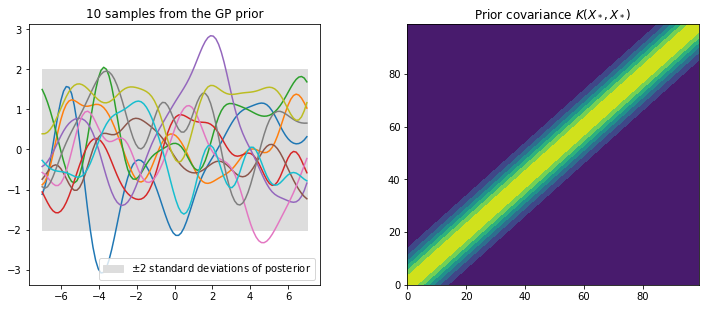

In [125]:
# draw samples from the prior 
Ns = 10 # number of samples
f_prior = sample(0, Kss, jitter, N=10)

# compute standard deviation for plotting
std = np.sqrt(np.diag(Kss))

fig = plt.figure(figsize=(12, 12))
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# plot the sampled values as functions of x_star
plt.subplot(2, 2, 1)
plt.plot(x_star, f_prior)
plt.title('%i samples from the GP prior' % Ns)
plt.fill_between(x_star.flatten(), 0-2*std, 0+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
plt.legend()

# visualise the covariance function
plt.subplot(2, 2, 2)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(Kss)
plt.show()

This prior represents a probability distribution directly over the space of functions $f(\mathbf{x})$ with zero mean. The squared exponential covariance function calculates how all of the locations on the input axis vary with one and other, i.e. it computes the covariance between all input locations. If input points $x_n$ and $x_m$ are similar then the corresponding $f(x_n)$ and $f(x_m)$ will be strongly correlated in comparison to less similar points. The prior represents functions of $f$ that are all jointly Gaussian, where the covariance matrix encodes the behavior of the function.

## Prediction with Noise Free Observations

We are not primarily interested in drawing random functions from our prior but instead want to incorporate the information contained in the training data with the prior. Lets consider our observations to be noise free, that is, we know $\{(\mathbf{x}_i, f_i) | i = 1,...,n\}$. The joint distribution between the training targets $\mathbf{f}$ and the test targets $\mathbf{f}_*$ is given then by,

\begin{align}
\begin{bmatrix}
\mathbf{f}\\
\mathbf{f}_*\\
\end{bmatrix} &\sim  \mathcal{N}
\begin{pmatrix}
\mathbf{0},
\begin{bmatrix}
K(X, X) & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{bmatrix}
\end{pmatrix}.
\end{align}

Conditioning the joint Gaussian prior distribution on the observations leads to the key predictive equations for Gaussian process regression,

$$\mathbf{f}_* | X, X_*, \mathbf{f} \sim \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*))$$

where the mean $\bar{\mathbf{f}}_*$ and covariance $\text{cov}(\mathbf{f}_*))$ matrices are given by,

\begin{align}
\bar{\mathbf{f}}_* &\triangleq \mathbb{E}[\mathbf{f}_* | X, X_*, \mathbf{f}] = K(X_*, X)K(X,X)^{-1}\mathbf{f} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)K(X,X)^{-1} K(X, X_*).
\end{align}

Function values can be sampled from this joint posterior distribution.

Lets now create the underlying function that we are trying to recover (the sine function).

In [126]:
f = lambda x: np.sin(x) + 0.1*np.cos(2*x) # underlying function

Lets generate some training inputs and map them through our function $\mathbf{f}$ to obtain our training data set $\{(\mathbf{x}_i, f_i) | i = 1,...,n \}$. Lets also visualise our training data set and our underlying function.

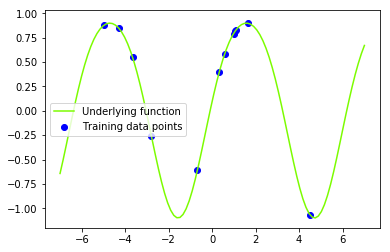

In [127]:
N = 12  # number of training points
x_train = np.random.uniform(x_min, x_max, size=(N, 1))  # training inputs
# x_train = np.linspace(x_min, x_max, N).reshape(N, 1)  # training inputs
y_train = f(x_train)  # training outputs (f) - these are noise free observations of the underlying function f

# plt.title('Underlying function $f(x)=sin(x)$ and dummy data set ')
plt.plot(x_star, f(x_star), color='lawngreen', label='Underlying function')
plt.scatter(x_train, y_train, color='b', label='Training data points')
plt.legend()
plt.show()

We want to combine our training data with our Gaussian process prior in order to reach the joint posterior distribution. As we saw earlier we can condition the joint Gaussian prior distribution on the observations, where the predictive mean and covariance are given by,

\begin{align}
\bar{\mathbf{f}}_* &= K(X_*, X)K(X,X)^{-1}\mathbf{f}, \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)K(X,X)^{-1} K(X, X_*).
\end{align}

[Rasmussen and Williams](http://www.gaussianprocess.org/gpml/) provide a practical algorithm for implementing Gaussian process regression, calculating  both the predictive mean $\bar{f}_*$ and covariance $\mathbb{V}[f_*]$,

**input**: $\mathbf{X}$ (inputs), $\mathbf{y}$ (targets), $k$ (covariance function), $\sigma_n^2$ (noise level), $\mathbf{x}_*$ (test input)

\begin{align}
L &:= \text{cholesky}(K + \sigma_n^2 I) \\
\mathbf{\alpha} &:= L^T\backslash(L\backslash\mathbf{y}) \\
\bar{f}_* &:= \mathbf{k}_*^T\mathbf{\alpha} \\
\mathbf{v} &:= L \backslash \mathbf{k}_* \\
\mathbb{V}[f_*] &:= k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{v}^T \mathbf{v}
\end{align}

**return**: $\bar{f}_*$ (mean), $\mathbb{V}[f_*]$ (variance)

This algorithm addresses the matrix inversion and uses the Cholesky factorization.

In [128]:
def gp_regression(X, y, k, x_star, s_f, l):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, s_f, l))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(X, x_star, s_f, l).T @ a
    
    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, s_f, l))
    var = k(x_star, x_star, s_f, l) - v.T @ v

    return mu, var

Lets now calculate our predictive mean and variance given an initial guess for the hyperparameters ($\sigma_f^2 = 1$, $l = 1$).

In [129]:
l = 1 # lengthscale
var_f = 1  # signal variance
mu, var = gp_regression(x_train, y_train, kernel, x_star, var_f, l)

In order to visualise our posterior lets create a helper function that will plot the mean and variance overlayed on our training data set and also draw and plot some samples from our posterior distribution.

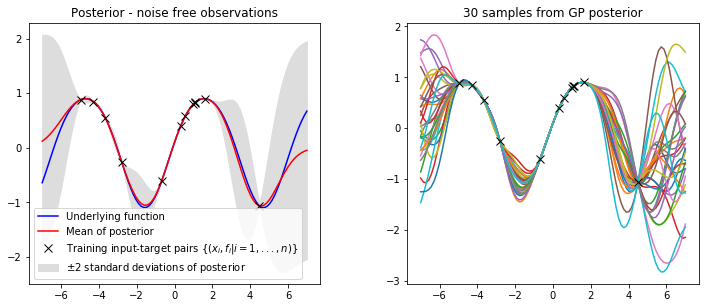

In [130]:
def plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="GP posterior"):
    std = np.sqrt(np.diag(var))  # square root the variance to get standard deviation
    f_post = sample(mu, var, jitter, N=num_samples)  # draw samples from posterior
    
    fig = plt.figure(figsize=(12, 12))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)

    # plot underlying function, training data, posterior mean and +/- 2 standard deviations
    plt.subplot(2, 2, 1)
    plt.title(title)
    plt.fill_between(x_star.flatten(), mu.flatten()-2*std, mu.flatten()+2*std, label='$\pm$2 standard deviations of posterior', color="#dddddd")
    plt.plot(x_star, f(x_star), 'b-', label='Underlying function')
    plt.plot(x_star, mu, 'r-', label='Mean of posterior')  # plot mean of posterior
    plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, f_i | i = 1,...,n)\}$')
    plt.legend()

    # plot samples from posterior
    plt.subplot(2, 2, 2)
    plt.title('%i samples from GP posterior' % num_samples)
    plt.plot(x_star, f_post)  # plot samples from posterior
    plt.plot(x_train, y_train, 'kx', ms=8 ,label='Training input-target pairs $\{(x_i, y_i | i = 1,...,n)\}$')
    plt.show()

plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - noise free observations")

It is clear that we have combined our observed data with our GP prior to obtain a model of our data. Lets plot the prior and posterior covariance matrices to get a deeper understanding of what's going on.

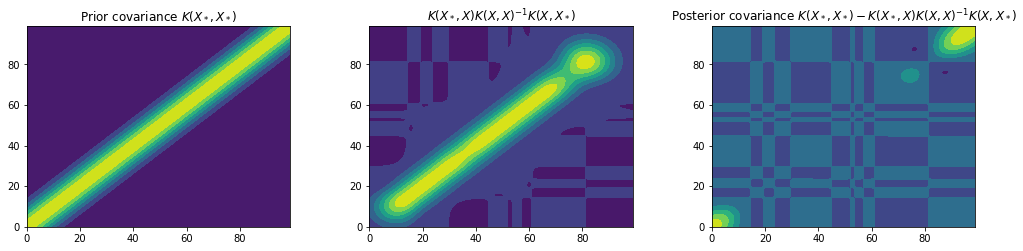

In [131]:
kk = kernel(x_star, x_train, var_f, l) @ np.linalg.inv(kernel(x_train, x_train, var_f, l)) @ kernel(x_train, x_star, var_f, l)

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(3, 3, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(Kss)

plt.subplot(3, 3, 2)
plt.title("$K(X_*, X) K(X, X)^{-1} K(X, X_*)$")  # TODO: This represents the effect of the likelihood but can it be called the likelihood covariance???
plt.contourf(kk)

plt.subplot(3, 3, 3)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(var)
plt.show()

These figures show the covariance matrices for the prior, likelihood and posterior respectively. It is clear that the posterior restricts the prior to contain only those functions which agree with the observed data points.

### Predictions with Noisy Observations

In most cases we do not observe values of the underlying function $\mathbf{f}$, but instead only observe noisy versions generated by,

$$y = f(\mathbf{x}) + \epsilon.$$

Assuming additive independent identically distributed Gaussian noise $\epsilon$ with variance $\sigma_n^2$ , the prior on the noisy observations becomes,

$$\text{cov}(\mathbf{y}) = K(X, X)+\sigma_n^2 \mathbf{I}.$$

The joint distribution between the observed target values $\mathbf{y}$ and the function values at test locations $\mathbf{f}_*$ under the prior is given then by,

\begin{align}
\begin{bmatrix}
\mathbf{y}\\
\mathbf{f}_*\\
\end{bmatrix} &\sim  \mathcal{N}
\begin{pmatrix}
\mathbf{0}
\begin{bmatrix}
K(X, X) + \sigma_n^2 \mathbf{I} & K(X, X_*) \\
K(X_*, X) & K(X_*, X_*)
\end{bmatrix}
\end{pmatrix}
\end{align}

This leads to the key predictive equations for Gaussian process regression,

\begin{align}
\mathbf{f}_* | X, \mathbf{y}, X_* &\sim \mathcal{N}(\bar{\mathbf{f}}_*, \text{cov}(\mathbf{f}_*)) \\
\bar{\mathbf{f}}_* &\triangleq \mathbb{E}[\mathbf{f}_* | X, \mathbf{y}, X_*] = K(X_*, X)[K(X,X) + \sigma_n^2 \mathbf{I}]^{-1}\mathbf{y} \\
\text{cov}(\mathbf{f}_*) &= K(X_*, X_*) - K(X_*, X)[K(X,X) + \sigma_n^2 \mathbf{I}]^{-1} K(X, X_*)
\end{align}

Lets now create a function that can generate noisy observations $\mathbf{y}$ of our underlying function $f$.

In [132]:
y = lambda x, s: f(x) + np.random.normal(0, np.sqrt(s), x.shape) # generate noisy observations

Lets generate a new data set with additive i.i.d. Gaussian noise $\sigma \sim \mathcal{N}(0, 0.05)$.

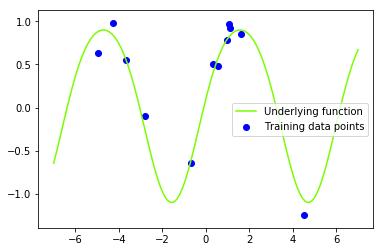

In [133]:
s_n_gen = 0.01  # noise variance
y_train = y(x_train, s_n_gen)  # observed target values (y)

# plt.title('Sinusoidal data set')
plt.plot(x_star, f(x_star), color='lawngreen', label='Underlying function')
plt.scatter(x_train, y_train, color='b', label='Training data points')
plt.legend()
plt.show()

We can now re-implement our gp_regression function to account for the noise variance term. This function is similar to before except we now add the noise variance $\sigma_n^2$ to the variance $\mathbb{V}[f_*]$.

In [134]:
def gp_regression_noisy(X, y, k, x_star, var_f, var_n, l):
    # calculate mean
    Lxx = np.linalg.cholesky(k(X, X, var_f, l) + var_n*np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    mu = k(X, x_star, var_f, l).T @ a
    
    # calculate variance
    v = np.linalg.solve(Lxx, k(X, x_star, var_f, l))
    var = k(x_star, x_star, var_f, l) - v.T @ v

    return mu, var

Lets guess our hyperparameters and visualise our posterior at the test locations we specified earlier.

In [135]:
var_f = 1  # signal variance
var_n = 0.1  # noise variance
l = 1  # lengthscale

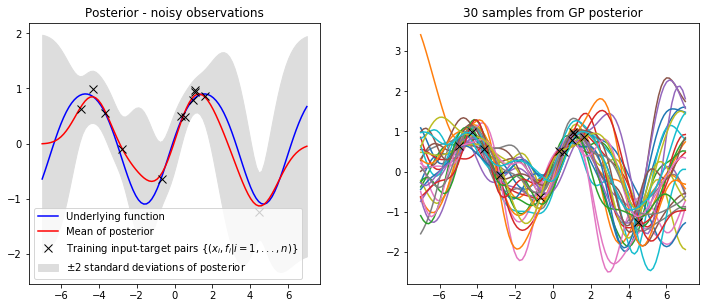

In [136]:
mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, var_f, var_n, l)
plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - noisy observations")

Similar to before we can plot the covariance matrices to gain a deeper understanding of how the prior has been combined with the data to obtain our predicitive posterior.

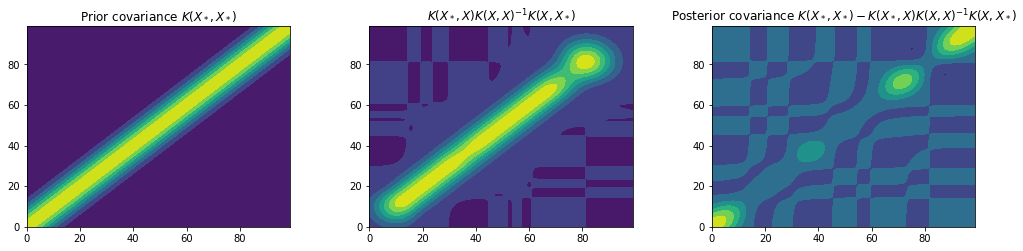

In [137]:
kk = kernel(x_star, x_train, var_f, l) @ np.linalg.inv(kernel(x_train, x_train, var_f, l)) @ kernel(x_train, x_star, var_f, l)

fig = plt.figure(figsize=(17, 17))
plt.subplots_adjust(wspace=0.3, hspace=0.8)

plt.subplot(3, 3, 1)
plt.title("Prior covariance $K(X_*, X_*)$")
plt.contourf(Kss)

plt.subplot(3, 3, 2)
plt.title("$K(X_*, X) K(X, X)^{-1} K(X, X_*)$")  # TODO: This represents the effect of the likelihood but can it be called the likelihood covariance???
plt.contourf(kk)

plt.subplot(3, 3, 3)
plt.title("Posterior covariance $K(X_*, X_*) - K(X_*, X) K(X, X)^{-1} K(X, X_*)$")
plt.contourf(var)
plt.show()

We have now successfully implemented Gaussian process regression for both noise free and noisy data. However, in many practical applications, it may not be easy to specify all of the hyper-parameters ($\sigma_f$, $\sigma_n$, $l$). For this reason we will now look into applying Bayesian inference to Gaussian process regression so that we can infer the hyper-parameters from our data, providing automatic Ocam's razor.

## Hyper-parameter Optimisation using Marginal Likelihood

The hyper-parameters can be set by maximizing the log marginal likelihood. The marginal likelihood (or evidence) $p(\mathbf{y}|X)$ is the integral of the likelihood times the prior,

$$
p(\mathbf{y}|X) = \int p(\mathbf{y}| \mathbf{f}, X) p(\mathbf{f}|X) d \mathbf{f}.
$$

The name arises due to the marginalisation over the function values $\mathbf{f}$. The Gaussian process model leads to a prior that is Gaussian $\mathbf{f}|X \sim \mathcal{N}(0, K)$, which can be written in log form as,

$$
\text{log}p(\mathbf{f}|X) = - \frac{1}{2} \mathbf{f}^T K^{-1} \mathbf{f} - \frac{1}{2} \text{log}|K| - \frac{n}{2} \text{log}2\pi.
$$

The likelihood is assumed to be a factorized Gaussian $\mathbf{y}|\mathbf{f} \sim \mathcal{N}(\mathbf{f}, K + \sigma_n^2 \mathbf{I})$ so we can use Equations A.7 and A.8 (page 200) from from [Rasmussen and Williams](http://www.gaussianprocess.org/gpml/) to perform the integration. This results in the log marginal likelihood,

$$
\text{log}p(\mathbf{y}|X) = - \frac{1}{2} \mathbf{y}^T (K + \sigma_n^2 \mathbf{I})^{-1} \mathbf{y} - \frac{1}{2} \text{log}|K + \sigma^2_n \mathbf{I} | - \frac{n}{2} \text{log}2\pi
$$

Referring back to the algorithm in the previous section we can compute the log marginal likelihood,

**input**: $\mathbf{X}$ (inputs), $\mathbf{y}$ (targets), $k$ (covariance function), $\sigma_n^2$ (noise level), $\mathbf{x}_*$ (test input)

\begin{align}
L &:= \text{cholesky}(K + \sigma_n^2 I) \\
\mathbf{\alpha} &:= L^T\backslash(L\backslash\mathbf{y}) \\
\bar{f}_* &:= \mathbf{k}_*^T\mathbf{\alpha} \\
\mathbf{v} &:= L \backslash \mathbf{k}_* \\
\mathbb{V}[f_*] &:= k(\mathbf{x}_*, \mathbf{x}_*) - \mathbf{v}^T \mathbf{v} \\
\text{log}p(\mathbf{y}|X) &:= - \frac{1}{2} \mathbf{y}^T \mathbf{\alpha} - \sum_i \text{log} L_{ii} - \frac{n}{2} \text{log}2\pi
\end{align}

**return**: $\bar{f}_*$ (mean), $\mathbb{V}[f_*]$ (variance), $\text{log}p(\mathbf{y}|X)$ (log marginal likelihood)

Lets create a function that implements the objective function for our optimisation. SciPy provides a set of optimisation tools that we can use here, however, SciPy attempts to minimize functions and therefore our objective function must return the negative log likelihood.

In [138]:
def f_opt(x, *args):
    """ Calculates the value of the objective (negative log marginal likelihood) for parameters in *args."""
    X, y, k, x_star = args
    var_f, l, var_n = x
    
    Lxx = np.linalg.cholesky(k(X, X, var_f, l) + var_n*np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    
#     return -(- 0.5 * y.T @ a - np.log(np.trace(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)
    return -(- 0.5 * y.T @ a - 0.5*np.trace(np.log(Lxx)) - X.shape[0]*np.log(2 * math.pi)/2)

In order to set the hyperparameters by maximizing the log marginal likelihood we need the partial derivatives of the marginal likelihood w.r.t. the hyperparameters,

\begin{align}
\frac{\partial}{\partial \theta_j} \text{log}p(\mathbf{y}|X, \mathbf{\theta}) &= \frac{1}{2} \mathbf{y}^T K^{-1} \frac{\partial K}{\partial \theta_j} K^{-1} \mathbf{y} - \frac{1}{2} \text{tr}(K^{-1} \frac{\partial K}{\partial \theta_j}) \\
&= - \frac{1}{2} \text{tr}((\alpha \alpha^T - K^{-1}) \frac{\partial K}{\partial \theta_j}) \ \text{where} \ \alpha = K^{-1} \mathbf{y}
\end{align}

Lets create a function that can calculate the partial derivative of the marginal likelihood w.r.t. a given hyper-parameter. The function will receive $\frac{\partial K}{\partial \theta_j}$ as an input and can therefore calculate the partial derivative of the marginal likelihood w.r.t. the hyper-parameter associated with the partial derivative that it is passed.

In [139]:
def dLdT(a,iKxx, dKdt):
    """
    Calculates the partial derivatives of the marginal likelihood w.r.t. the hyper-parameters
        dKdt: partial derivative of of the covariance function wrt a hyper-parameter
    """
    return 0.5 * np.trace(np.dot((a @ a.T - iKxx), dKdt))

We want to optimise the signal variance $\sigma_f$, lengthscale $l$ and noise variance $\sigma_n$ so therefore require the partial derivatives of our covariance function w.r.t. each parameter. Rembering that our covariance function is,

$$ K(\mathbf{x}_p, \mathbf{x}_q) = \sigma_f^2 \text{exp}(- \frac{|\mathbf{x}_p - \mathbf{x}_q|^2}{2l^2}) + \sigma_n^2 \delta_{pq}.$$

the partial derivatives are given by,

\begin{align}
\frac{\partial K}{\partial \sigma_f} &= 2 \sigma_f \text{exp}(- \frac{|\mathbf{x}_p - \mathbf{x}_q|^2}{2l^2}) \\
\frac{\partial K}{\partial l} &= \sigma_f^2 \text{exp}(- \frac{|\mathbf{x}_p - \mathbf{x}_q|^2}{2l^2}) \frac{|\mathbf{x}_p - \mathbf{x}_q|^2}{l^3} \\
\frac{\partial K}{\partial \sigma_n} &= 2 \sigma_n \delta_{pq}
\end{align}

Lets now implement functions to calculate each of these derivatives.

In [140]:
def dKdsf(x1, x2, var_f, l):
    """Gradient of SE kernel wrt the signal variance s_f"""
    return  2*np.sqrt(var_f) * np.exp((-cdist(x1, x2)**2) / (2*l**2))

def dKdL(x1, x2, var_f, l):
    """Gradient of SE kernel wrt the lengthscale l"""
    return var_f**2 * np.exp((-cdist(x1, x2)**2) / (2*l**2)) * (-cdist(x1, x2)**2) / (l**3)

def dKdsn(x1, x2, var_n):
    """Gradient of SE kernel wrt the lengthscale noise variance s_n"""
    return 2 * np.sqrt(np.diag(var_n))

We now have an objective function and the gradients w.r.t. the hyper-parameters that we wish to learn. We can perform the optimisation using gradient descent (there are many optimisation algorithms but they are out of the scope of this notebook). In order to do this we must first create a function that returns the Jacobian (matrix of first-order partial derivatives) of our objective function.

In [141]:
def dfx(x, *args):
    """Calculates the gradients of the objective with respect to signal variance, lengthscale and noise variance"""
    X, y, k, x_star = args
    var_f, l, var_n = x
    
    Kxx = k(X, X, var_f, l)
    Lxx = np.linalg.cholesky(Kxx + var_n*np.eye(X.shape[0]))
    a = np.linalg.solve(Lxx.T, np.linalg.solve(Lxx, y))
    
    iKxx = np.linalg.inv(Kxx + var_n*np.eye(X.shape[0]))
    
    J = np.empty([3,])
    J[0] = dLdT(a, iKxx, dKdsf(X, X, var_f, l)) # gradient for signal variance var_f
    J[1] = dLdT(a, iKxx, dKdL(X, X, var_f, l)) # gradient for lengthscale l
    J[2] = dLdT(a, iKxx, dKdsn(X, X, var_n)) # gradient for noise variance var_n
    
    return J

We are now ready to import SciPys optimisation package and perform the optimisation using our objective function and Jacobian. However, we must first bound the hyper-parameters so that they are always positive.

In [142]:
import scipy.optimize as opt
import pprint

bounds = [[0, np.inf], [0, np.inf], [0.0001, np.inf]]  # bound the hyper-parameters to always be positive
args = (x_train, y_train, kernel, x_star)  # arguments used in objective function
x0 = [1, 1, 0.1]  # initial guess at parameters being optimised [s_f, l, s_n]
res = opt.fmin_l_bfgs_b(f_opt, x0, args=args, approx_grad=True, bounds=bounds)  # call the optimisation algorithm 
# print(res)

/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.
/Users/aidanscannell/miniconda3/envs/ml-env/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


Lets print out the hyperparameter values that we have learned.

In [143]:
var_f = res[0][0] # signal variance
l = res[0][1]  # lengthscale
var_n = res[0][2]  # noise variance

print("Signal variance: %.6f\nLengthscale: %.6f\nNoise variance: %.6f" % (var_f, l, var_n))

Signal variance: 1.726486
Lengthscale: 1.569913
Noise variance: 0.027944


Fianlly, lets compare the posterior with our initial hyperparameters against the posterior with our optimised hyperparameters.

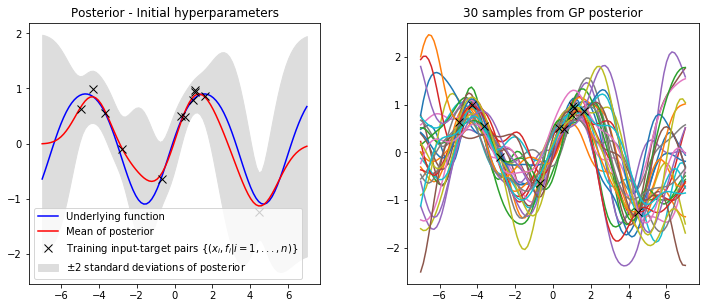

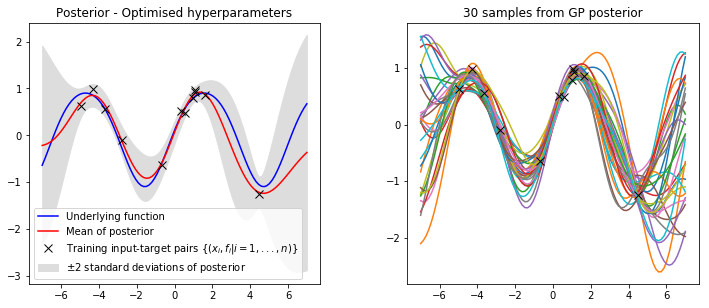

In [144]:
mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, x0[0], x0[2], x0[1])
plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - Initial hyperparameters")

mu, var = gp_regression_noisy(x_train, y_train, kernel, x_star, var_f, var_n, l)
plot_posterior(x_train, y_train, x_star, mu, var, num_samples=30, title="Posterior - Optimised hyperparameters")

It is clear that our optimised hyperparameters model our data much better. This is because we have used the log marginal likelihood of our model,

$$
\text{log}p(\mathbf{y}|X) = - \frac{1}{2} \mathbf{y}^T (K + \sigma_n^2 \mathbf{I})^{-1} \mathbf{y} - \frac{1}{2} \text{log}|K + \sigma^2_n \mathbf{I} | - \frac{n}{2} \text{log}2\pi
$$

to optimise the hyperparameters, which provides automatic Occam's razor. The first term $- \frac{1}{2} \mathbf{y}^T (K + \sigma_n^2 \mathbf{I})^{-1} \mathbf{y}$ is the only term involving the observed targets and represents the data fit, the second term $- \frac{1}{2} \text{log}|K + \sigma^2_n \mathbf{I} |$ acts as a complexity penalty that depends only upon the variance function and the inputs and the thrid term $- \frac{n}{2} \text{log}2\pi$ acts as a normalisation constant.

## Conclusion

I decided to write this post (and accompanying notebook) to consolidate my understnading of the mathematical theory underpinning GP regression. Please note that implementing GP regression in [GPy](https://github.com/SheffieldML/GPy) is much simpler (as you don't need to understand the theory) and lots of extra functionality is provided. For implementations that require good performance I would recommend looking at [GPflow](https://github.com/GPflow/GPflow), a Gaussian process library written in [TensorFlow](https://www.tensorflow.org/). I hope the post has been helpful and please let me know if you spot any mistakes (I'm sure there are a few!) or if anything is not clear :)